In [168]:
## Preprocessing du DataFrame

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,f1_score # pour voir l'efficacité globale du modèle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [169]:
df = pd.read_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/features950_data.csv",index_col=0)
df.index = df.id
df = df.drop(columns='id',axis=1)

## Pour la validation
df_test = pd.read_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/test_features950_data.csv",index_col='id')
df_test = df_test.iloc[:,1:]

In [170]:
columns_spectre = ['rms.mean', 'rms.std', 'rms.min', 'rms.max', 'sc.mean','sc.std', 'sc.min', 'sc.max', 'sb.mean', 'sb.std', 'sb.min', 'sb.max','sfs.mean', 'sfs.std', 'sfs.min',"sfs.max"]

##Train
df_spectre = df.copy()[["target"] + columns_spectre ]
df_fourier = df.copy().drop(columns=columns_spectre,axis=1)

##Validation
df_test_spectre = df_test.copy()[columns_spectre]
df_test_fourier = df_test.copy().drop(columns=columns_spectre,axis=1)

##Passage au log2 sur les amplitudes de fréquences 
eps = 1e-10
df_fourier.iloc[:,1:] = np.log(df_fourier.iloc[:,1:]+eps)/np.log(2)
df_test_fourier = np.log(df_test_fourier+eps)/np.log(2)

#Standardisation des données train 
scaler_spectre = StandardScaler()
scaler_spectre.fit(df_spectre.iloc[:,1:])
df_spectre.iloc[:,1:] = scaler_spectre.transform(df_spectre.iloc[:,1:])

scaler_fourier= StandardScaler()
scaler_fourier.fit(df_fourier.iloc[:,1:])
df_fourier.iloc[:,1:] = scaler_fourier.transform(df_fourier.iloc[:,1:])

#Standardisation des données de validation

index = df_test_spectre.index
df_test_spectre= pd.DataFrame(scaler_spectre.transform(df_test_spectre),columns=df_test_spectre.columns)
df_test_spectre.index = index 

index = df_test_fourier.index
df_test_fourier = pd.DataFrame(scaler_fourier.transform(df_test_fourier),columns=df_test_fourier.columns)
df_test_fourier.index = index 

In [171]:
#Train test split

trainset_s, testset_s = train_test_split(df_spectre, test_size=0.2,random_state=0)
trainset_f, testset_f = train_test_split(df_fourier, test_size=0.2,random_state=0)

def preprocessing(dataframe):
    return dataframe.drop('target',axis=1), dataframe.target

X_S_train,Y_S_train = preprocessing(trainset_s)
X_S_test,Y_S_test = preprocessing(testset_s)

X_F_train,Y_F_train = preprocessing(trainset_f)
X_F_test,Y_F_test = preprocessing(testset_f)

# Une fonction d'évaluation

In [172]:
def evaluation_model(model,X_train,X_test,Y_train,Y_test, batch_size=20, epochs=80,lr=0.001):
    """
    Cette fonction entraîne une modèle de réseau de neurones de classification binaire pour ensuite l'évaluer sur des données test 
    L'algorithme d'optimisation de l'apprentissage est Adam  
    """
    
    #Pour stopper quand les courbes de coût se croisent
    earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    #Paramètre du learning rate pour l'algorithme Adam
    adam_optimizer = Adam(learning_rate=lr)

    # Compilateur du modèle avec le nouvel optimiseur
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    #garder en mémoire l'apprentissage
    history =  model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test,Y_test),callbacks=[earlystopping] )

    # Prédire les probabilités pour la classe positive
    Y_proba_pred = model.predict(X_test)

    # Calculer les scores TPR (True Positive Rate) et FPR (False Positive Rate)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_proba_pred)

    #Trouver le bon indice pour le seuil de décision, au milieu de la courbe Roc
    indice = int(np.floor(len(thresholds)/2))
    print( "voici le seuil médian" ,thresholds[indice-1])

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    #Prédiction sur le seuil précédent
    Y_pred = Y_proba_pred > thresholds[indice-1]
    
    #Rapport de classification  
    matrix_conf = confusion_matrix(Y_test,Y_pred)
    print(classification_report(Y_test,Y_pred))

    ##Matrice de confusion 
    plt.figure(figsize=(5,5))
    sns.heatmap(matrix_conf,annot=True,fmt='g')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.show()

    ##Historique de l'apprentissage

    #Score
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Accuracy (training data)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    #Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='loss (training data)')
    plt.plot(history.history['val_loss'], label='loss(validation data)')
    plt.title('Loss over epochs')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Tracer la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})') # aire sous la courbe
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC (Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.show()
    


# Modèle sur les données spectrale

Epoch 1/50
186/186 [==============================] - 2s 4ms/step - loss: 0.5146 - accuracy: 0.7678 - val_loss: 0.3389 - val_accuracy: 0.8643
Epoch 2/50
186/186 [==============================] - 1s 3ms/step - loss: 0.3703 - accuracy: 0.8601 - val_loss: 0.3077 - val_accuracy: 0.8824
Epoch 3/50
186/186 [==============================] - 1s 3ms/step - loss: 0.3378 - accuracy: 0.8708 - val_loss: 0.2940 - val_accuracy: 0.8889
Epoch 4/50
186/186 [==============================] - 1s 3ms/step - loss: 0.3234 - accuracy: 0.8782 - val_loss: 0.2783 - val_accuracy: 0.8960
Epoch 5/50
186/186 [==============================] - 1s 3ms/step - loss: 0.3046 - accuracy: 0.8862 - val_loss: 0.2666 - val_accuracy: 0.8986
Epoch 6/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2936 - accuracy: 0.8905 - val_loss: 0.2602 - val_accuracy: 0.9027
Epoch 7/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2889 - accuracy: 0.8931 - val_loss: 0.2533 - val_accuracy: 0.9035
Epoch 

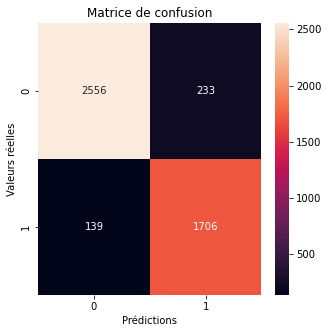

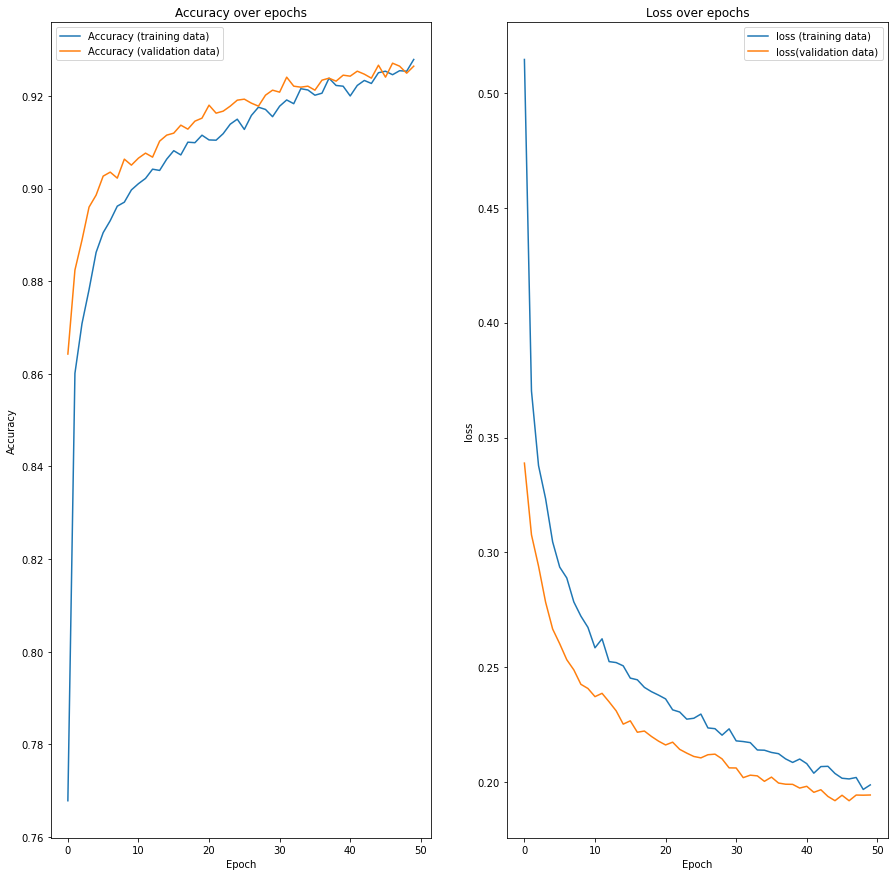

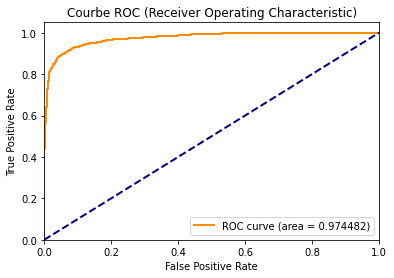

In [177]:
neuro_spectre = Sequential()
neuro_spectre.add(Dense(128,input_dim=X_S_train.shape[1], activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_spectre.add(Dropout(0.25))

neuro_spectre.add(Dense(64, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_spectre.add(Dropout(0.25))

neuro_spectre.add(Dense(32, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_spectre.add(Dropout(0.25))

neuro_spectre.add(Dense(16, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_spectre.add(Dropout(0.25))

neuro_spectre.add(Dense(1, activation='sigmoid'))  # Sortie binaire

evaluation_model(neuro_spectre,X_S_train,X_S_test,Y_S_train,Y_S_test, batch_size=100, epochs=50,lr=0.0005)


724/724 [==============================] - 1s 1ms/step


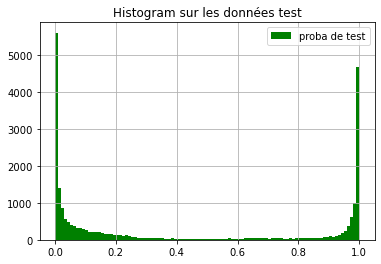

30/30 [==============================] - 0s 1ms/step


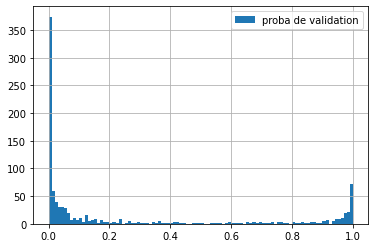

30/30 [==============================] - 0s 2ms/step


In [183]:
plt.hist(neuro_spectre.predict(df_spectre.drop(columns='target',axis=1)),100,color='g',density=False,label='proba de test')
plt.grid()
plt.legend()
plt.title("Histogram sur les données test")
plt.show()


plt.hist(neuro_spectre.predict(df_test_spectre),100,density=False,label='proba de validation')
plt.grid()
plt.legend()
plt.show()

df_soumission8 = df_test_spectre.copy().drop(df_test_spectre.columns,axis = 1)
df_soumission8['pos_label'] = neuro_spectre.predict(df_test_spectre)
df_soumission8.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission8.csv")


# Modèle sur les données fourier

Epoch 1/25
38/38 [==============================] - 3s 64ms/step - loss: 0.6401 - accuracy: 0.6300 - val_loss: 0.5090 - val_accuracy: 0.7628
Epoch 2/25
38/38 [==============================] - 3s 69ms/step - loss: 0.5120 - accuracy: 0.7502 - val_loss: 0.3965 - val_accuracy: 0.8297
Epoch 3/25
38/38 [==============================] - 3s 71ms/step - loss: 0.4118 - accuracy: 0.8284 - val_loss: 0.3229 - val_accuracy: 0.8640
Epoch 4/25
38/38 [==============================] - 3s 72ms/step - loss: 0.3431 - accuracy: 0.8645 - val_loss: 0.2746 - val_accuracy: 0.8951
Epoch 5/25
38/38 [==============================] - 2s 65ms/step - loss: 0.3048 - accuracy: 0.8852 - val_loss: 0.2696 - val_accuracy: 0.8953
Epoch 6/25
38/38 [==============================] - 2s 61ms/step - loss: 0.2726 - accuracy: 0.8987 - val_loss: 0.2392 - val_accuracy: 0.9135
Epoch 7/25
38/38 [==============================] - 2s 60ms/step - loss: 0.2524 - accuracy: 0.9060 - val_loss: 0.2194 - val_accuracy: 0.9180
Epoch 8/25
38

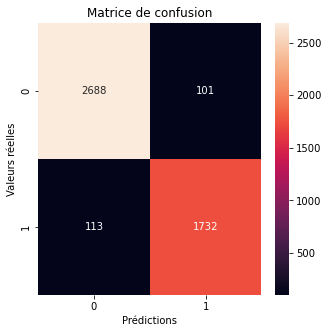

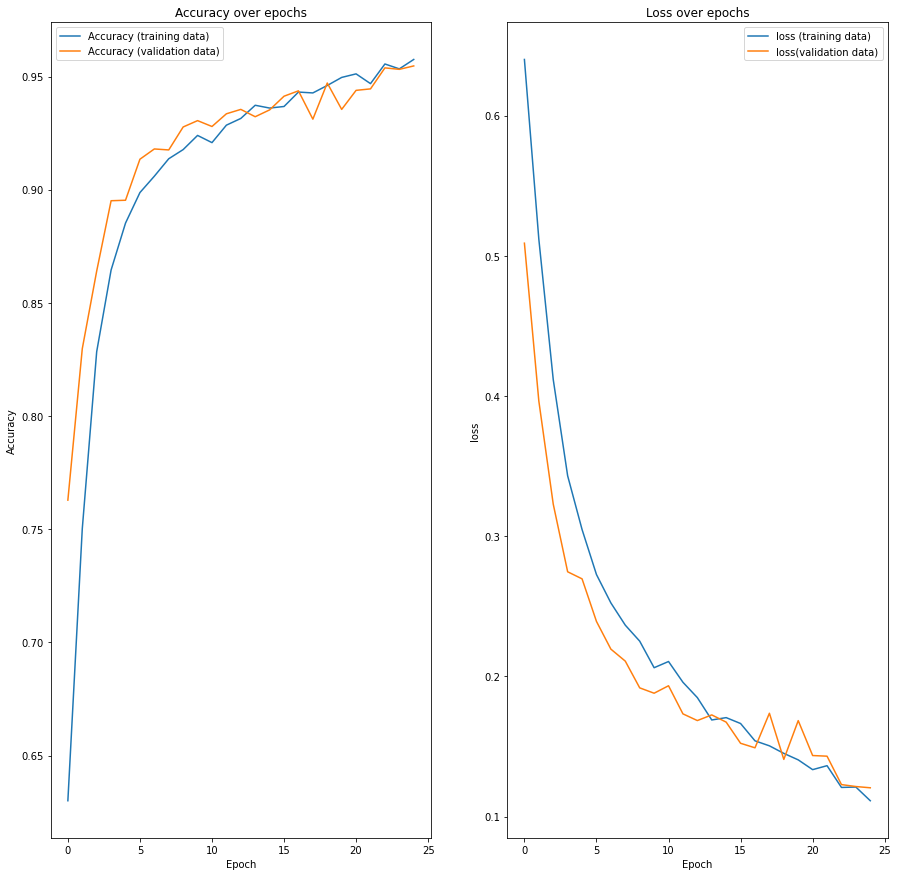

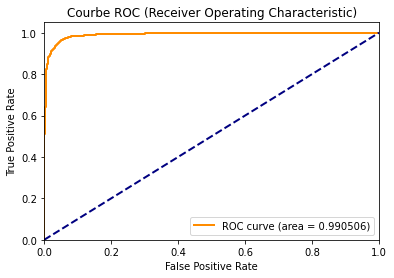

In [189]:

neuro_fourier = Sequential()
neuro_fourier.add(Dense(1000,input_dim=X_F_train.shape[1], activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_fourier.add(Dropout(0.25))

neuro_fourier.add(Dense(500, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_fourier.add(Dropout(0.25))

neuro_fourier.add(Dense(250, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_fourier.add(Dropout(0.25))

neuro_fourier.add(Dense(100, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_fourier.add(Dropout(0.25))

neuro_fourier.add(Dense(50, activation='relu'))  # input_shape doit correspondre à la forme de vos données d'entrée
neuro_fourier.add(Dropout(0.25))


neuro_fourier.add(Dense(1, activation='sigmoid'))  # Sortie binaire

evaluation_model(neuro_fourier,X_F_train,X_F_test,Y_F_train,Y_F_test, batch_size=500, epochs=25,lr=0.0001)




Epoch 1/25
38/38 [==============================] - 4s 68ms/step - loss: 0.1137 - accuracy: 0.9580 - val_loss: 0.1349 - val_accuracy: 0.9502
Epoch 2/25
38/38 [==============================] - 2s 66ms/step - loss: 0.1148 - accuracy: 0.9577 - val_loss: 0.1201 - val_accuracy: 0.9536
Epoch 3/25
38/38 [==============================] - 3s 71ms/step - loss: 0.1013 - accuracy: 0.9624 - val_loss: 0.1131 - val_accuracy: 0.9568
Epoch 4/25
38/38 [==============================] - 2s 62ms/step - loss: 0.1012 - accuracy: 0.9610 - val_loss: 0.1332 - val_accuracy: 0.9458
Epoch 5/25
38/38 [==============================] - 2s 61ms/step - loss: 0.1117 - accuracy: 0.9592 - val_loss: 0.1174 - val_accuracy: 0.9540
Epoch 6/25
38/38 [==============================] - 2s 64ms/step - loss: 0.0935 - accuracy: 0.9640 - val_loss: 0.1111 - val_accuracy: 0.9594
Epoch 7/25
38/38 [==============================] - 3s 67ms/step - loss: 0.0897 - accuracy: 0.9660 - val_loss: 0.1082 - val_accuracy: 0.9592
Epoch 8/25
38

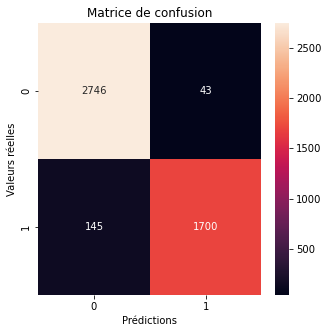

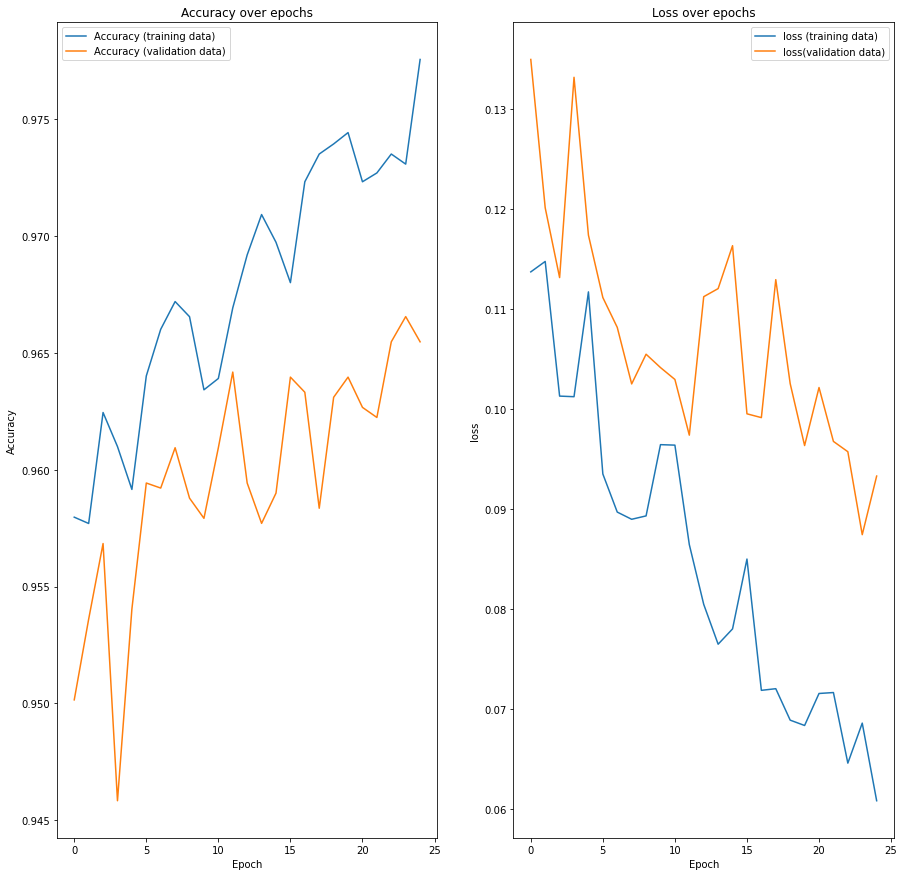

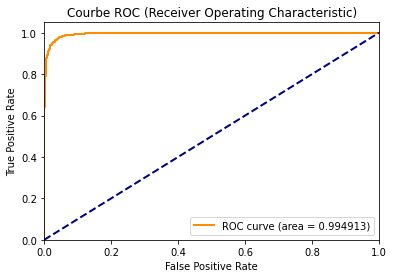

In [191]:
neuro_fourier1 = neuro_fourier
evaluation_model(neuro_fourier1,X_F_train,X_F_test,Y_F_train,Y_F_test, batch_size=500, epochs=25,lr=0.0001)


724/724 [==============================] - 3s 3ms/step


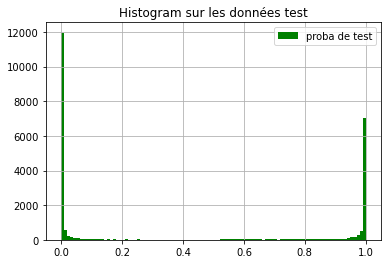

30/30 [==============================] - 0s 4ms/step


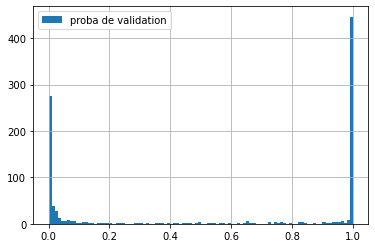

30/30 [==============================] - 0s 5ms/step


In [193]:
plt.hist(neuro_fourier.predict(df_fourier.drop(columns='target',axis=1)),100,color='g',density=False,label='proba de test')
plt.grid()
plt.legend()
plt.title("Histogram sur les données test")
plt.show()


plt.hist(neuro_fourier.predict(df_test_fourier),100,density=False,label='proba de validation')
plt.grid()
plt.legend()
plt.show()


df_soumission9 = df_test_fourier.copy().drop(df_test_fourier.columns,axis = 1)
df_soumission9['pos_label'] = neuro_fourier.predict(df_test_fourier)
df_soumission9.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission9.csv")

# Export des modèles entrainés

In [72]:
import pickle

In [79]:
# Entraînez votre modèle comme vous l'avez fait

# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_fourier_MLP.pkl', 'wb') as fichier:
    pickle.dump(neuro_fourier, fichier)

# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_spectre_MLP.pkl', 'wb') as fichier:
    pickle.dump(neuro_spectre, fichier)

# Import modèles

In [80]:
# Chargez le modèle à partir du fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_spectre_MLP.pkl', 'rb') as fichier:
    neuro_spectre = pickle.load(fichier)

with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_fourier_MLP.pkl', 'rb') as fichier:
    neuro_fourier = pickle.load(fichier)

In [131]:
#### Pour la partie train du data set

X_F_tr = X_F_train.copy()
X_F_te = X_F_test.copy()

X_S_tr = X_S_train.copy()
X_S_te = X_S_test.copy()

columns_spectre = X_S_tr.columns
columns_fourier = X_F_tr.columns

X_F_tr = X_F_tr.drop(columns = columns_fourier, axis=1)
X_F_te = X_F_te.drop(columns = columns_fourier, axis=1)

X_S_tr = X_S_tr.drop(columns = columns_spectre, axis=1)
X_S_te = X_S_te.drop(columns = columns_spectre, axis=1)

# Créez deux modèles à partir des modèles neuro_fourier et neuro_spectre en spécifiant l'entrée et la sortie souhaitées
fourier_moins2= Model(inputs=neuro_fourier.input, outputs=neuro_fourier.layers[-2].output)
spectre_moins2= Model(inputs=neuro_spectre.input, outputs=neuro_spectre.layers[-2].output)

M = pd.DataFrame(fourier_moins2.predict(X_F_train))
M.index = X_F_tr.index
X_F_tr = pd.concat([X_F_tr, M], axis=1)

M = pd.DataFrame(fourier_moins2.predict(X_F_test))
M.index = X_F_te.index
X_F_te = pd.concat([X_F_te, M], axis=1)

M = pd.DataFrame(spectre_moins2.predict(X_S_train))
M.index = X_S_tr.index
X_S_tr = pd.concat([X_S_tr, M], axis=1)

M = pd.DataFrame(spectre_moins2.predict(X_S_test))
M.index = X_S_te.index
X_S_te = pd.concat([X_S_te, M], axis=1)


#### Pour la partie validation du data set

df_test_S = df_test_spectre.copy()

df_test_F = df_test_fourier.copy()

columns_spectre = df_test_S.columns
columns_fourier = df_test_F.columns

df_test_S  = df_test_S .drop(columns = columns_spectre, axis=1)
df_test_F = df_test_F.drop(columns = columns_fourier, axis=1)

M = pd.DataFrame(spectre_moins2.predict(df_test_spectre))
M.index = df_test_S.index
df_test_S = pd.concat([df_test_S, M], axis=1)

M = pd.DataFrame(fourier_moins2.predict(df_test_fourier))
M.index = df_test_F.index
df_test_F = pd.concat([df_test_F, M], axis=1)



 37/145 [======>.......................] - ETA: 0s

/tmp/ipykernel_9994/2914322335.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_F_tr = pd.concat([X_F_tr, M], axis=1)


 95/580 [===>..........................] - ETA: 0s

/tmp/ipykernel_9994/2914322335.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_F_te = pd.concat([X_F_te, M], axis=1)


 55/145 [==========>...................] - ETA: 0s

/tmp/ipykernel_9994/2914322335.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_S_tr = pd.concat([X_S_tr, M], axis=1)


 1/30 [>.............................] - ETA: 0s

/tmp/ipykernel_9994/2914322335.py:36: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_S_te = pd.concat([X_S_te, M], axis=1)
/tmp/ipykernel_9994/2914322335.py:53: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_test_S = pd.concat([df_test_S, M], axis=1)


30/30 [==============================] - 0s 4ms/step


/tmp/ipykernel_9994/2914322335.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_test_F = pd.concat([df_test_F, M], axis=1)


In [158]:
X_F = pd.concat([X_F_tr,X_F_te])
X_S = pd.concat([X_S_tr,X_S_te])

X_FS = pd.concat([X_F,X_S],axis=1)
Y_FS = pd.concat([Y_S_train,Y_S_test])

X_VAL = pd.concat([df_test_F,df_test_S],axis=1)


#Standardisation des données train et validation
scaler_SF = StandardScaler()
scaler_SF.fit(X_FS.iloc[:,:])
X_FS.iloc[:,:] = scaler_SF.transform(X_FS.iloc[:,:])
X_VAL.iloc[:,:] = scaler_SF.transform(X_VAL.iloc[:,:])


# Train test split sur les nouvelles données


In [159]:

X_FS_train, X_FS_test , Y_FS_train, Y_FS_test = train_test_split(X_FS,Y_FS, test_size=0.4,random_state=1)

# Modèle Fourier/Spectre

Epoch 1/50
109/109 [==============================] - 2s 6ms/step - loss: 0.5943 - accuracy: 0.7365 - val_loss: 0.4595 - val_accuracy: 0.9803
Epoch 2/50
109/109 [==============================] - 0s 4ms/step - loss: 0.4429 - accuracy: 0.9068 - val_loss: 0.3201 - val_accuracy: 0.9815
Epoch 3/50
109/109 [==============================] - 0s 4ms/step - loss: 0.3308 - accuracy: 0.9517 - val_loss: 0.2245 - val_accuracy: 0.9820
Epoch 4/50
109/109 [==============================] - 0s 4ms/step - loss: 0.2456 - accuracy: 0.9683 - val_loss: 0.1610 - val_accuracy: 0.9820
Epoch 5/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1902 - accuracy: 0.9736 - val_loss: 0.1196 - val_accuracy: 0.9818
Epoch 6/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1547 - accuracy: 0.9763 - val_loss: 0.0929 - val_accuracy: 0.9820
Epoch 7/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1278 - accuracy: 0.9774 - val_loss: 0.0764 - val_accuracy: 0.9821
Epoch 

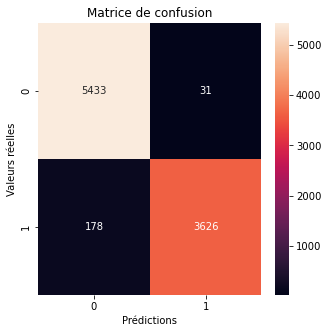

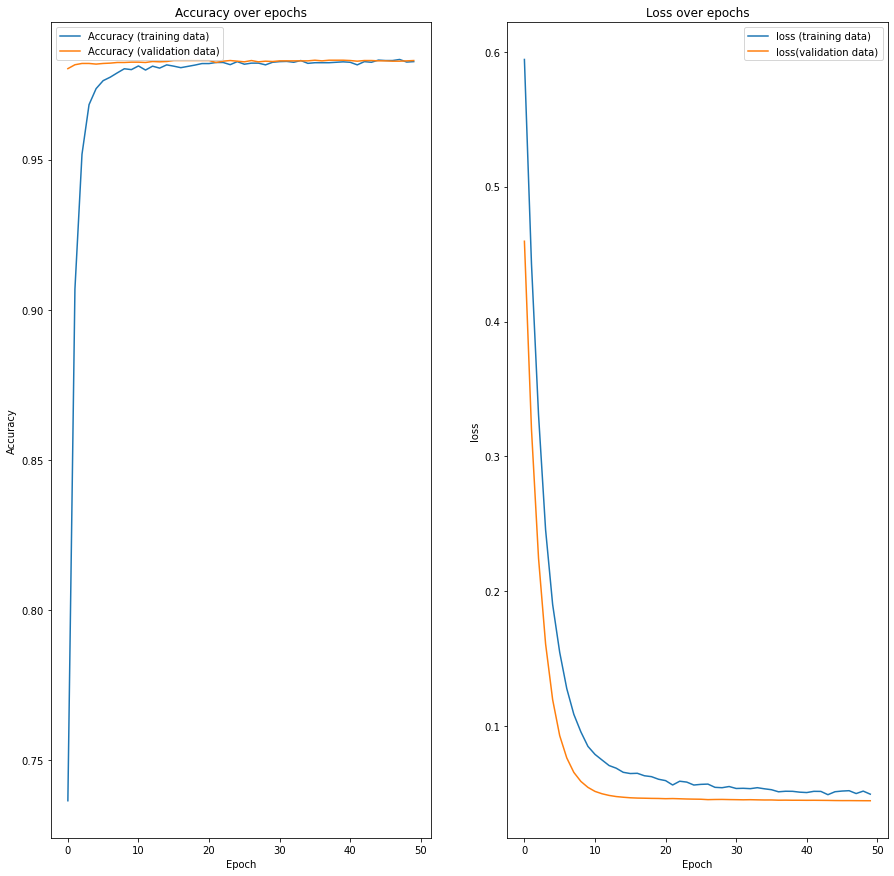

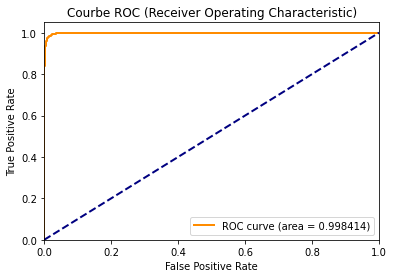

In [163]:

neuro_FS = Sequential()

neuro_FS.add(Dense(256,input_dim=X_FS_train.shape[1], activation='relu'))  

neuro_FS.add(Dense(128,input_dim=X_FS_train.shape[1], activation='relu'))  
neuro_FS.add(Dropout(0.25))

neuro_FS.add(Dense(64, activation='relu'))  
neuro_FS.add(Dropout(0.25))

neuro_FS.add(Dense(32, activation='relu'))  
neuro_FS.add(Dropout(0.25))

neuro_FS.add(Dense(1, activation='sigmoid'))  # Sortie binaire

evaluation_model(neuro_FS,X_FS_train,X_FS_test,Y_FS_train,Y_FS_test, batch_size=128, epochs=50,lr=0.00001)

724/724 [==============================] - 1s 1ms/step


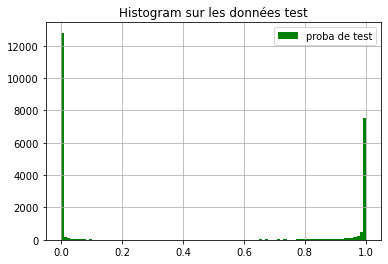

30/30 [==============================] - 0s 1ms/step


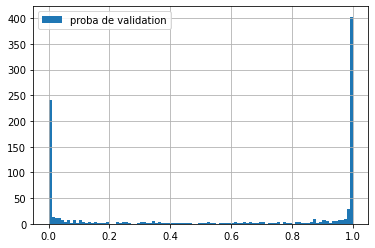

In [165]:
plt.hist(neuro_FS.predict(X_FS),100,color='g',density=False,label='proba de test')
plt.grid()
plt.legend()
plt.title("Histogram sur les données test")
plt.show()


plt.hist(neuro_FS.predict(X_VAL),100,density=False,label='proba de validation')
plt.grid()
plt.legend()
plt.show()

In [167]:
df_soumission7 = X_VAL.copy().drop(X_VAL.columns,axis = 1)
df_soumission7['pos_label'] = neuro_FS.predict(X_VAL)
df_soumission7.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission7.csv")



30/30 [==============================] - 0s 2ms/step
